# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

<br>

![YOLOv9 Benchmark](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov9-benchmark.jpeg)

**Figure 1.**  Comparisons of the real-time object detecors on MS
COCO dataset. The GELAN and PGI-based object detection
method surpassed all previous train-from-scratch methods in terms
of object detection performance. Source: "YOLOv9: Learning What You Want to Learn Using Programmable Gradient Information"

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Feb 26 03:38:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 147 (delta 16), reused 14 (delta 14), pack-reused 122
Receiving objects: 100% (147/147), 607.60 KiB | 4.90 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/kaggle/working/yolov9


**NOTE:** Let's install additional packages that will be useful later on.

In [4]:
!pip install -q roboflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.11 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.2 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.8.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.


## Imports

In [5]:
import roboflow

from IPython.display import Image

## Download model weights

**NOTE:** In the YOLOv9 paper, versions yolov9-s and yolov9-m are also mentioned, but the weights for these models are not yet available in the YOLOv9 repository.

In [6]:
!mkdir -p {HOME}/weights

In [7]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [8]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 Feb 26 03:39 .
drwxr-xr-x 5 root root      4096 Feb 26 03:38 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [9]:
%cd {HOME}/yolov9

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("boodsampledetails").project("detect_components-iwi74")
dataset = project.version(1).download("yolov7")

/kaggle/working/yolov9
visit https://app.roboflow.com/auth-cli to get your authentication token.


Paste the authentication token here:  ····································


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to detect_components-1 in yolov7pytorch:: 100%|██████████| 740/740 [00:00<00:00, 8676.72it/s]


## Train Custom Model

In [10]:
%%writefile utils/loss_tal.py
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.general import xywh2xyxy
from utils.metrics import bbox_iou
from utils.tal.anchor_generator import dist2bbox, make_anchors, bbox2dist
from utils.tal.assigner import TaskAlignedAssigner
from utils.torch_utils import de_parallel


def smooth_BCE(eps=0.1):  # https://github.com/ultralytics/yolov3/issues/238#issuecomment-598028441
    # return positive, negative label smoothing BCE targets
    return 1.0 - 0.5 * eps, 0.5 * eps


class VarifocalLoss(nn.Module):
    # Varifocal loss by Zhang et al. https://arxiv.org/abs/2008.13367
    def __init__(self):
        super().__init__()

    def forward(self, pred_score, gt_score, label, alpha=0.75, gamma=2.0):
        weight = alpha * pred_score.sigmoid().pow(gamma) * (1 - label) + gt_score * label
        with torch.cuda.amp.autocast(enabled=False):
            loss = (F.binary_cross_entropy_with_logits(pred_score.float(), gt_score.float(),
                                                       reduction="none") * weight).sum()
        return loss


class FocalLoss(nn.Module):
    # Wraps focal loss around existing loss_fcn(), i.e. criteria = FocalLoss(nn.BCEWithLogitsLoss(), gamma=1.5)
    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = "none"  # required to apply FL to each element

    def forward(self, pred, true):
        loss = self.loss_fcn(pred, true)
        # p_t = torch.exp(-loss)
        # loss *= self.alpha * (1.000001 - p_t) ** self.gamma  # non-zero power for gradient stability

        # TF implementation https://github.com/tensorflow/addons/blob/v0.7.1/tensorflow_addons/losses/focal_loss.py
        pred_prob = torch.sigmoid(pred)  # prob from logits
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # 'none'
            return loss


class BboxLoss(nn.Module):
    def __init__(self, reg_max, use_dfl=False):
        super().__init__()
        self.reg_max = reg_max
        self.use_dfl = use_dfl

    def forward(self, pred_dist, pred_bboxes, anchor_points, target_bboxes, target_scores, target_scores_sum, fg_mask):
        # iou loss
        bbox_mask = fg_mask.unsqueeze(-1).repeat([1, 1, 4])  # (b, h*w, 4)
        pred_bboxes_pos = torch.masked_select(pred_bboxes, bbox_mask).view(-1, 4)
        target_bboxes_pos = torch.masked_select(target_bboxes, bbox_mask).view(-1, 4)
        bbox_weight = torch.masked_select(target_scores.sum(-1), fg_mask).unsqueeze(-1)
        
        iou = bbox_iou(pred_bboxes_pos, target_bboxes_pos, xywh=False, CIoU=True)
        loss_iou = 1.0 - iou

        loss_iou *= bbox_weight
        loss_iou = loss_iou.sum() / target_scores_sum

        # dfl loss
        if self.use_dfl:
            dist_mask = fg_mask.unsqueeze(-1).repeat([1, 1, (self.reg_max + 1) * 4])
            pred_dist_pos = torch.masked_select(pred_dist, dist_mask).view(-1, 4, self.reg_max + 1)
            target_ltrb = bbox2dist(anchor_points, target_bboxes, self.reg_max)
            target_ltrb_pos = torch.masked_select(target_ltrb, bbox_mask).view(-1, 4)
            loss_dfl = self._df_loss(pred_dist_pos, target_ltrb_pos) * bbox_weight
            loss_dfl = loss_dfl.sum() / target_scores_sum
        else:
            loss_dfl = torch.tensor(0.0).to(pred_dist.device)

        return loss_iou, loss_dfl, iou

    def _df_loss(self, pred_dist, target):
        target_left = target.to(torch.long)
        target_right = target_left + 1
        weight_left = target_right.to(torch.float) - target
        weight_right = 1 - weight_left
        loss_left = F.cross_entropy(pred_dist.view(-1, self.reg_max + 1), target_left.view(-1), reduction="none").view(
            target_left.shape) * weight_left
        loss_right = F.cross_entropy(pred_dist.view(-1, self.reg_max + 1), target_right.view(-1),
                                     reduction="none").view(target_left.shape) * weight_right
        return (loss_left + loss_right).mean(-1, keepdim=True)


class ComputeLoss:
    # Compute losses
    def __init__(self, model, use_dfl=True):
        device = next(model.parameters()).device  # get model device
        h = model.hyp  # hyperparameters

        # Define criteria
        BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([h["cls_pw"]], device=device), reduction='none')

        # Class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
        self.cp, self.cn = smooth_BCE(eps=h.get("label_smoothing", 0.0))  # positive, negative BCE targets

        # Focal loss
        g = h["fl_gamma"]  # focal loss gamma
        if g > 0:
            BCEcls = FocalLoss(BCEcls, g)

        m = de_parallel(model).model[-1]  # Detect() module
        self.balance = {3: [4.0, 1.0, 0.4]}.get(m.nl, [4.0, 1.0, 0.25, 0.06, 0.02])  # P3-P7
        self.BCEcls = BCEcls
        self.hyp = h
        self.stride = m.stride  # model strides
        self.nc = m.nc  # number of classes
        self.nl = m.nl  # number of layers
        self.no = m.no
        self.reg_max = m.reg_max
        self.device = device

        self.assigner = TaskAlignedAssigner(topk=int(os.getenv('YOLOM', 10)),
                                            num_classes=self.nc,
                                            alpha=float(os.getenv('YOLOA', 0.5)),
                                            beta=float(os.getenv('YOLOB', 6.0)))
        self.bbox_loss = BboxLoss(m.reg_max - 1, use_dfl=use_dfl).to(device)
        self.proj = torch.arange(m.reg_max).float().to(device)  # / 120.0
        self.use_dfl = use_dfl

    def preprocess(self, targets, batch_size, scale_tensor):
        if targets.shape[0] == 0:
            out = torch.zeros(batch_size, 0, 5, device=self.device)
        else:
            i = targets[:, 0]  # image index
            _, counts = i.unique(return_counts=True)
            out = torch.zeros(batch_size, counts.max(), 5, device=self.device)
            for j in range(batch_size):
                matches = i == j
                n = matches.sum()
                if n:
                    out[j, :n] = targets[matches, 1:]
            out[..., 1:5] = xywh2xyxy(out[..., 1:5].mul_(scale_tensor))
        return out

    def bbox_decode(self, anchor_points, pred_dist):
        if self.use_dfl:
            b, a, c = pred_dist.shape  # batch, anchors, channels
            pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
            # pred_dist = pred_dist.view(b, a, c // 4, 4).transpose(2,3).softmax(3).matmul(self.proj.type(pred_dist.dtype))
            # pred_dist = (pred_dist.view(b, a, c // 4, 4).softmax(2) * self.proj.type(pred_dist.dtype).view(1, 1, -1, 1)).sum(2)
        return dist2bbox(pred_dist, anchor_points, xywh=False)

    def __call__(self, p, targets, img=None, epoch=0):
        loss = torch.zeros(3, device=self.device)  # box, cls, dfl
        feats = p[1] if isinstance(p, tuple) else p
        print(type(feats))
        #feats_tensors = [torch.tensor(xi) for xi in feats]

        pred_distri, pred_scores = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split(
            (self.reg_max * 4, self.nc), 1)
        pred_scores = pred_scores.permute(0, 2, 1).contiguous()
        pred_distri = pred_distri.permute(0, 2, 1).contiguous()

        dtype = pred_scores.dtype
        batch_size, grid_size = pred_scores.shape[:2]
        imgsz = torch.tensor(feats[0].shape[2:], device=self.device, dtype=dtype) * self.stride[0]  # image size (h,w)
        anchor_points, stride_tensor = make_anchors(feats, self.stride, 0.5)

        # targets
        targets = self.preprocess(targets, batch_size, scale_tensor=imgsz[[1, 0, 1, 0]])
        gt_labels, gt_bboxes = targets.split((1, 4), 2)  # cls, xyxy
        mask_gt = gt_bboxes.sum(2, keepdim=True).gt_(0)

        # pboxes
        pred_bboxes = self.bbox_decode(anchor_points, pred_distri)  # xyxy, (b, h*w, 4)

        target_labels, target_bboxes, target_scores, fg_mask = self.assigner(
            pred_scores.detach().sigmoid(),
            (pred_bboxes.detach() * stride_tensor).type(gt_bboxes.dtype),
            anchor_points * stride_tensor,
            gt_labels,
            gt_bboxes,
            mask_gt)

        target_bboxes /= stride_tensor
        target_scores_sum = max(target_scores.sum(), 1)

        # cls loss
        # loss[1] = self.varifocal_loss(pred_scores, target_scores, target_labels) / target_scores_sum  # VFL way
        loss[1] = self.BCEcls(pred_scores, target_scores.to(dtype)).sum() / target_scores_sum  # BCE

        # bbox loss
        if fg_mask.sum():
            loss[0], loss[2], iou = self.bbox_loss(pred_distri,
                                                   pred_bboxes,
                                                   anchor_points,
                                                   target_bboxes,
                                                   target_scores,
                                                   target_scores_sum,
                                                   fg_mask)

        loss[0] *= 7.5  # box gain
        loss[1] *= 0.5  # cls gain
        loss[2] *= 1.5  # dfl gain

        return loss.sum() * batch_size, loss.detach()  # loss(box, cls, dfl)

Overwriting utils/loss_tal.py


In [11]:
# %cd {HOME}/yolov9

!python train_dual.py \
--batch 16 --epochs 50 --img 416 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/yolov9-c.pt \
--cfg models/detect/yolov9-c.yaml \
--hyp hyp.scratch-high.yaml

2024-02-26 03:42:09.884586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 03:42:09.884742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 03:42:10.178248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train_dual: weights=/kaggle/working/weights/yolov9-c.pt, cfg=models/detect/yolov9-c.yaml, data=/kaggle/working/yolov9/detect_components-1/data.yaml, hyp=hyp.scratch-hi

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [12]:
!ls {HOME}/yolov9/runs/train/exp/

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1708918974.1c92931f11a3.110.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


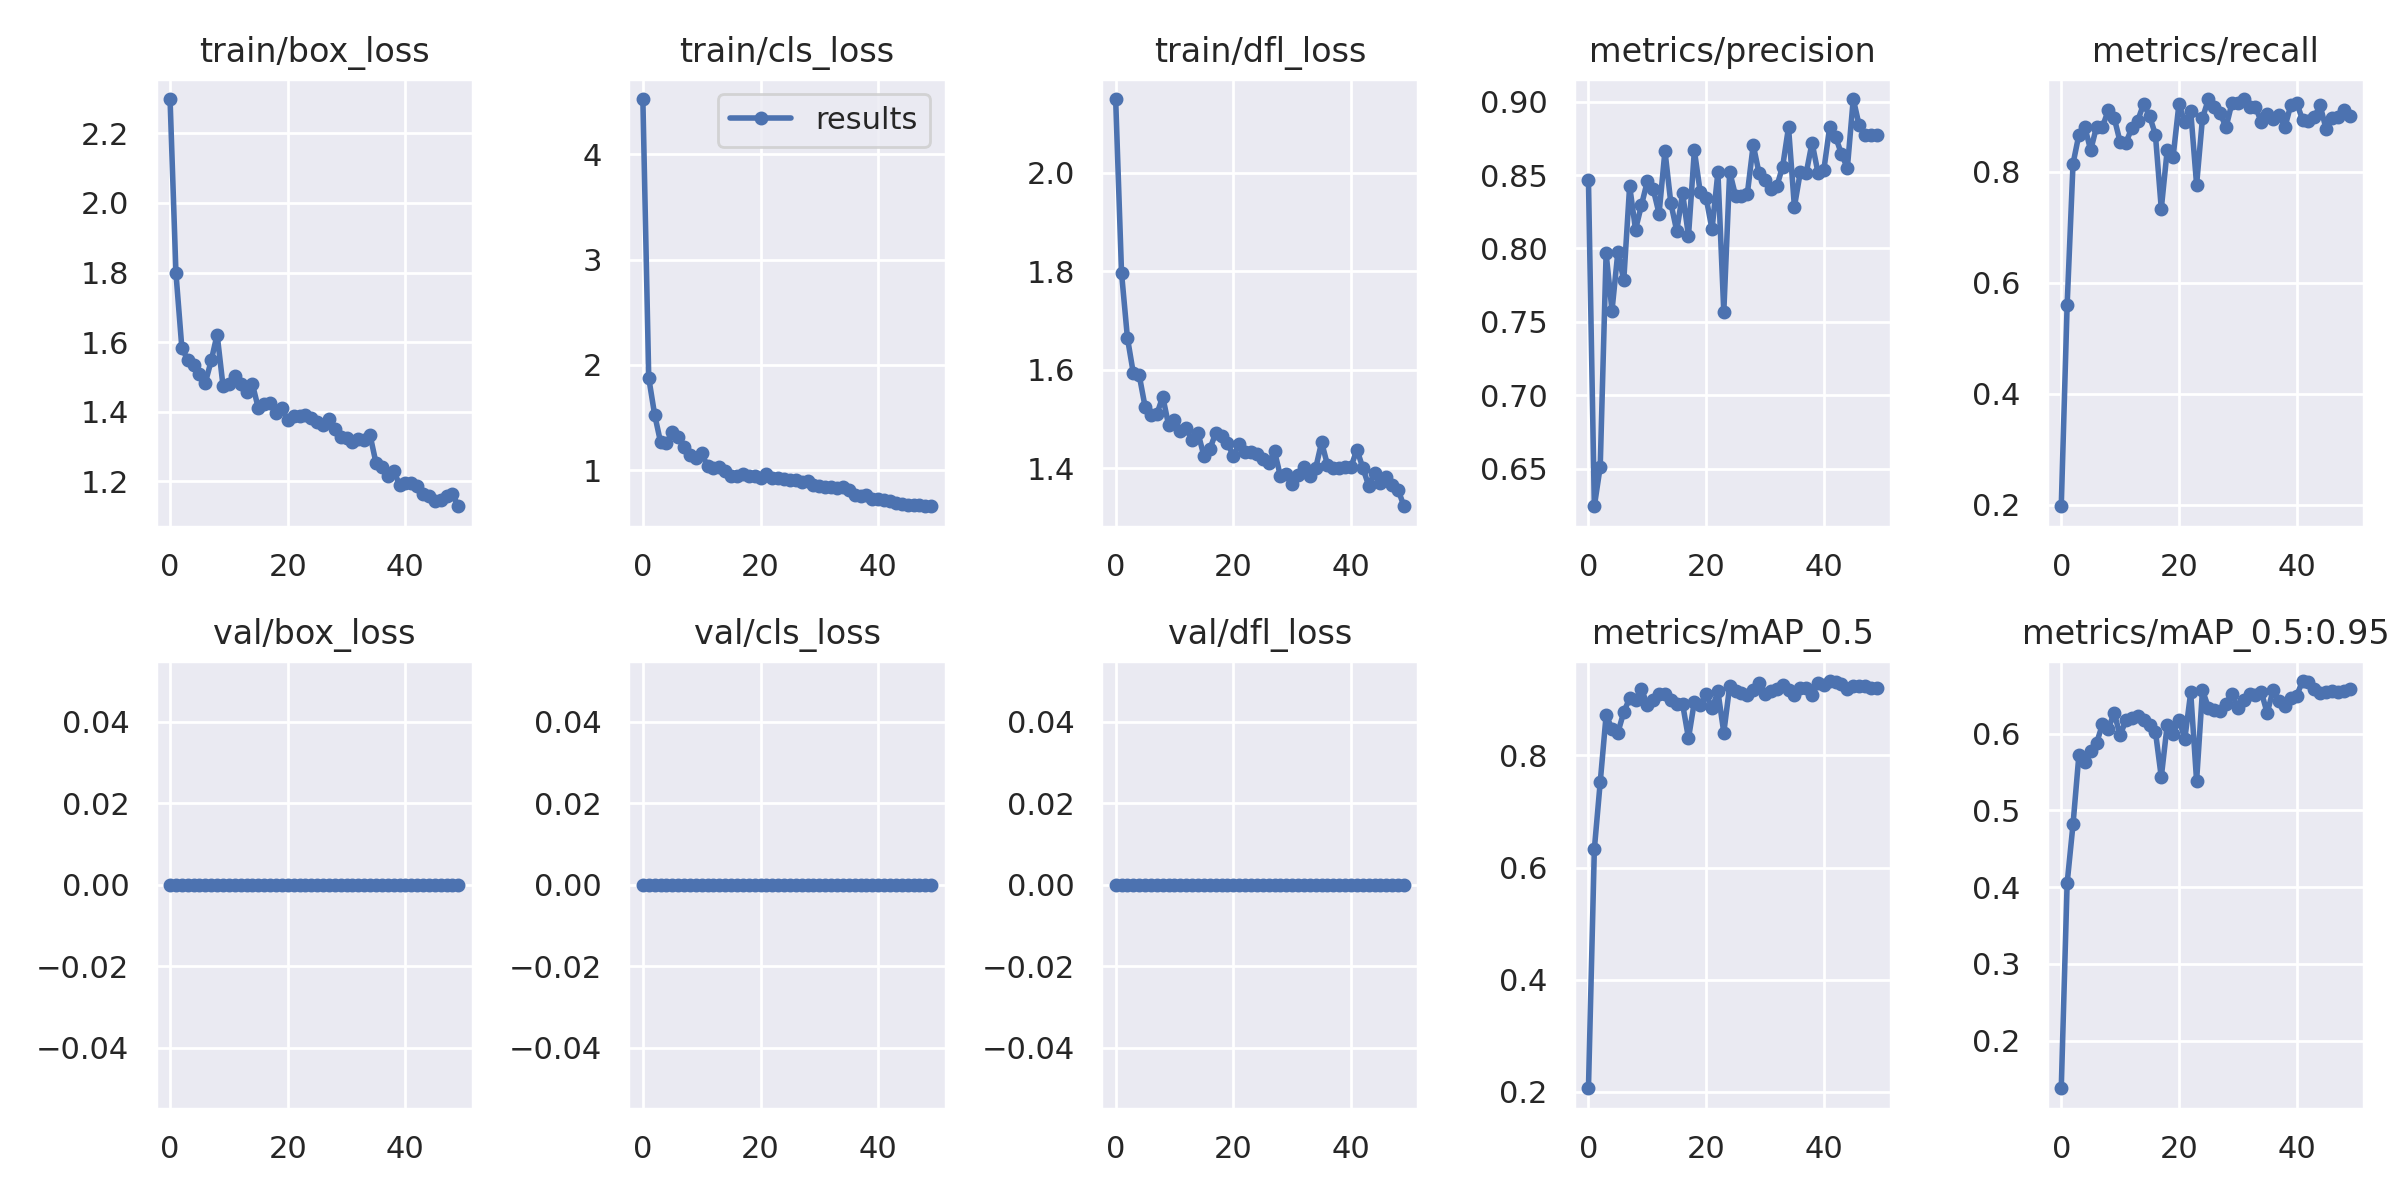

In [13]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

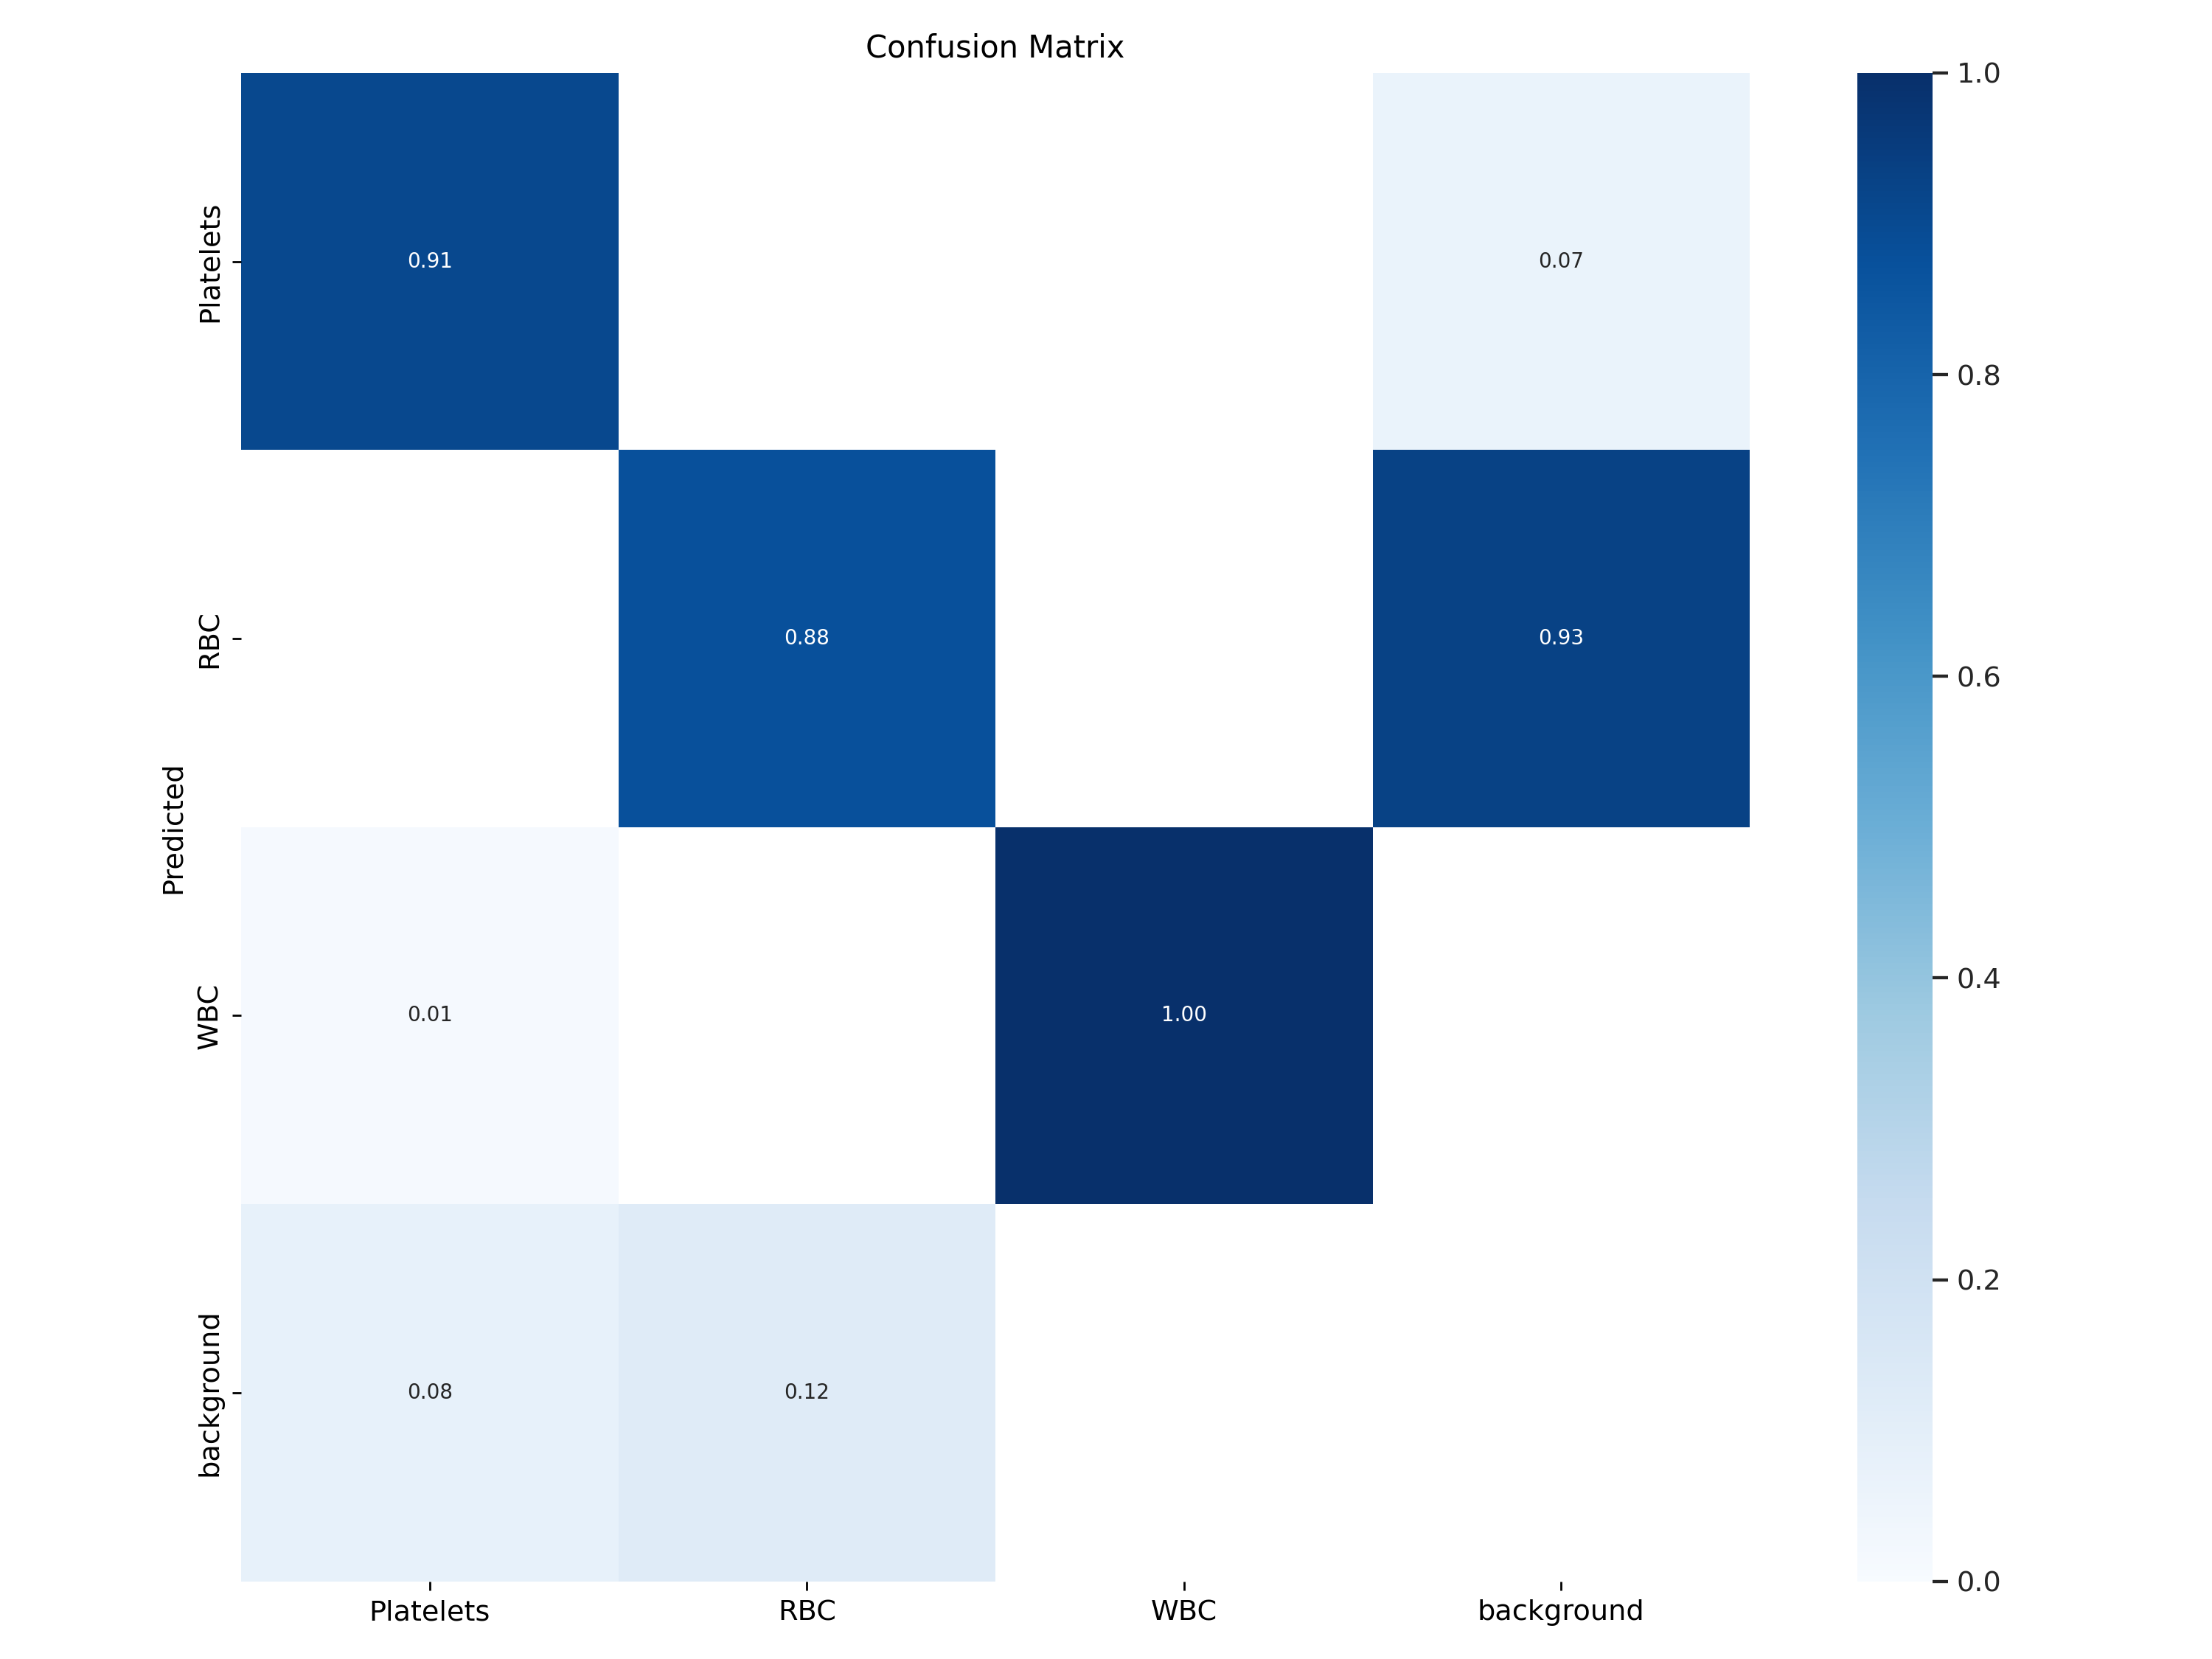

In [14]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

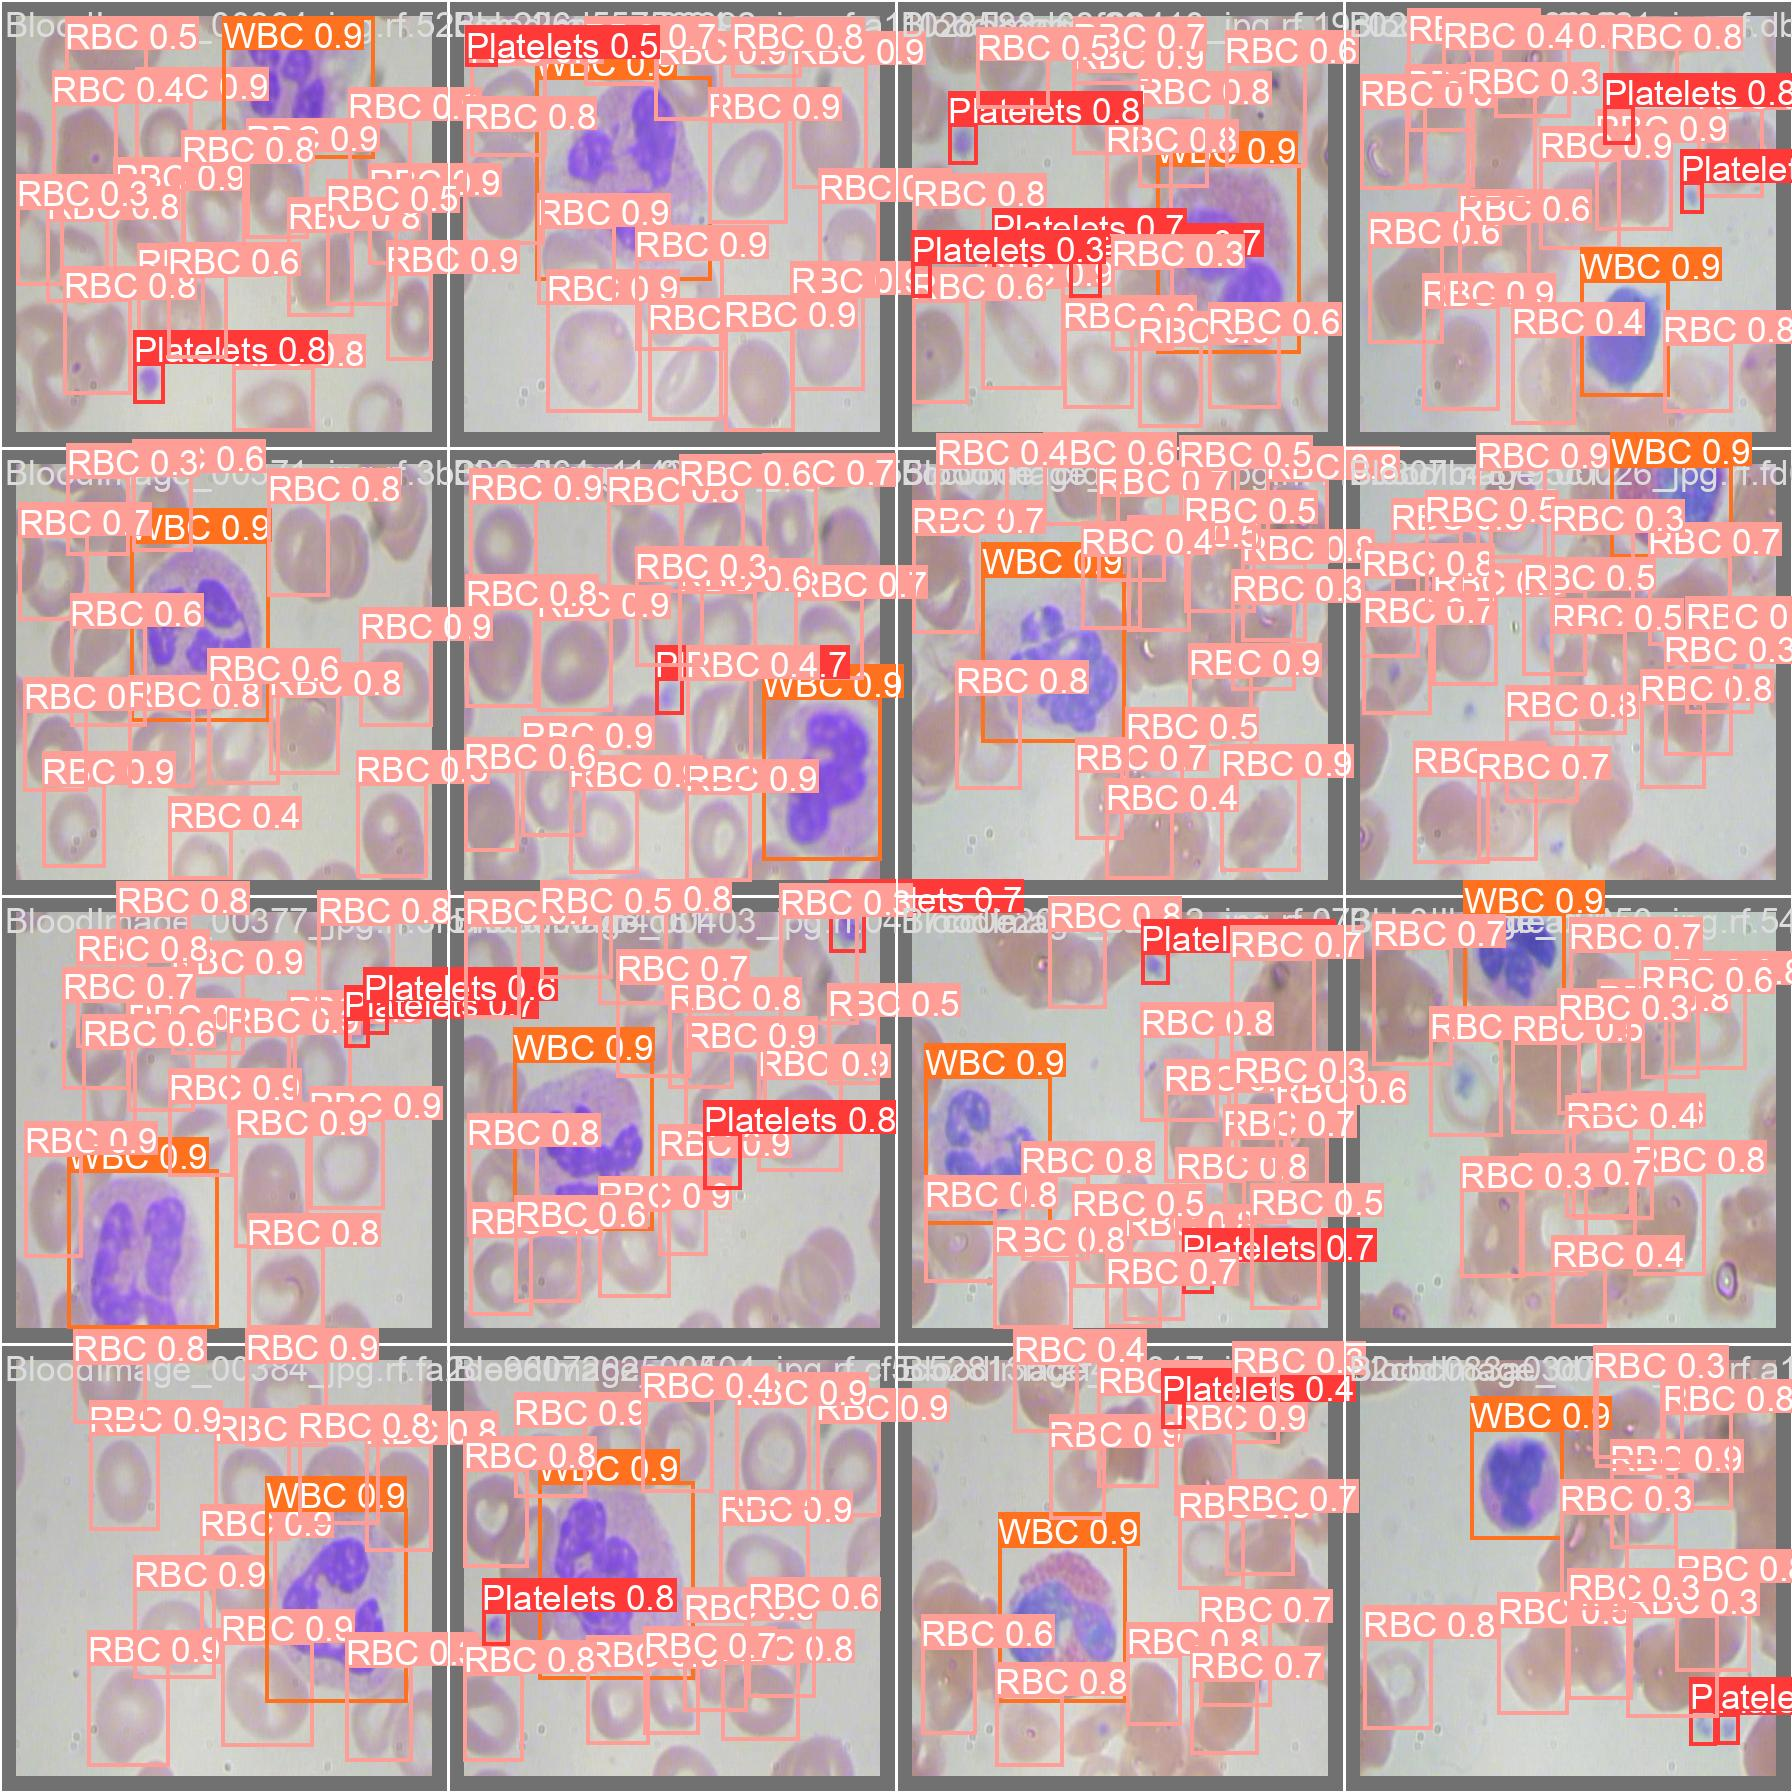

In [15]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [16]:
%cd {HOME}/yolov9

!python val_dual.py \
--img 416 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt


/kaggle/working/yolov9
val_dual: data=/kaggle/working/yolov9/detect_components-1/data.yaml, weights=['/kaggle/working/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yolov9-c summary: 724 layers, 50963250 parameters, 0 gradients, 237.7 GFLOPs
val: Scanning /kaggle/working/yolov9/detect_components-1/valid/labels.cache... 7
                 Class     Images  Instances          P          R      mAP50   
                   all         73        967      0.883      0.894      0.932       0.67
             Platelets         73         76      0.891      0.864       0.91      0.526
                   RBC         73 

## Inference with Custom Model

In [17]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/valid/images

detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/best.pt'], source=/kaggle/working/yolov9/detect_components-1/valid/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yolov9-c summary: 724 layers, 50963250 parameters, 0 gradients, 237.7 GFLOPs
image 1/73 /kaggle/working/yolov9/detect_components-1/valid/images/BloodImage_00000_jpg.rf.9dc79ecc991e70ec4c66d396de624ab9.jpg: 1280x1280 32 RBCs, 1 WBC, 246.4ms
image 2/73 /kaggle/working/yolov9/detect_components-1/valid/images/BloodImage_00004_jpg.rf.445b807b48795c12163e6ac815d34377.jpg: 1280

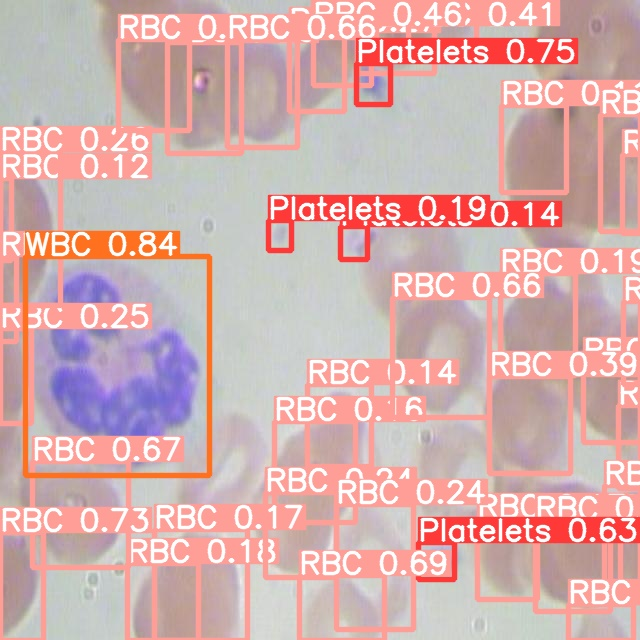

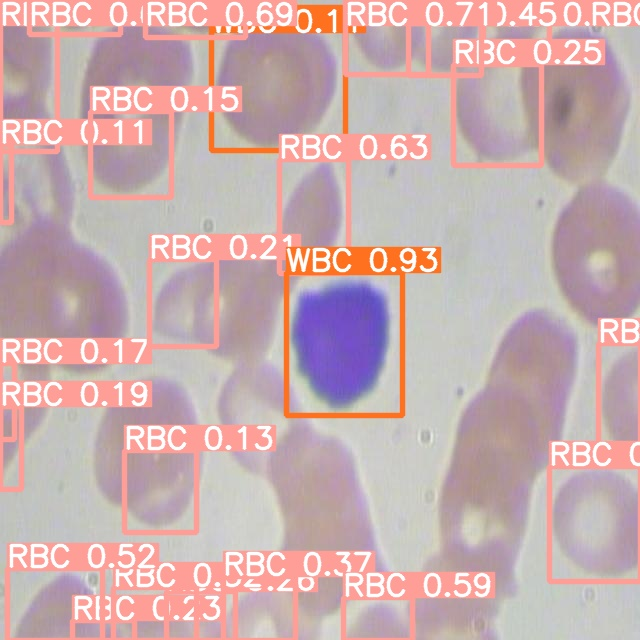

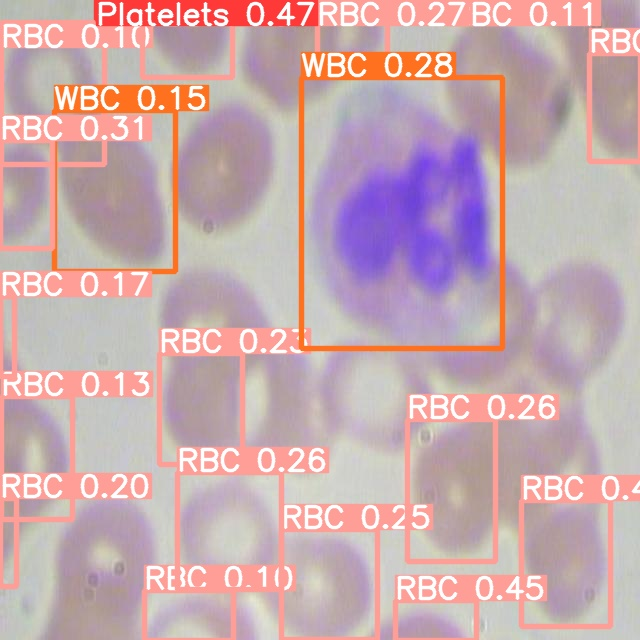

In [19]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:3]:
      display(Image(filename=image_path, width=416))
      print("\n")